In [1]:
%matplotlib inline
import warnings

warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import mdtraj as md

In [2]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import tidynamics as td

In [3]:
traj = md.load('data/traj_4.xtc',top= 'data/traj_4.pdb')


/anaconda3/envs/py35/lib/python3.5/site-packages/pyemma/__init__.py:130: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.5, you have 2.5.4.
  .format(latest=latest, current=current), category=UserWarning)


In [4]:
com = md.compute_center_of_mass(traj)

In [5]:
com.shape

(10000001, 3)

In [6]:
df = pd.DataFrame(com, columns=['x', 'y', 'z'])
df['t'] = traj.time/1000

In [7]:
coor_melt = pd.melt(frame=df, id_vars=['t'], value_vars=['x', 'y', 'z'], var_name='coord', )

In [8]:
coor_melt.head()

,t,coord,value
0,0.0000,x,1.350155
1,0.0001,x,1.295703
2,0.0002,x,1.305209
3,0.0003,x,1.287936
4,0.0004,x,1.325650


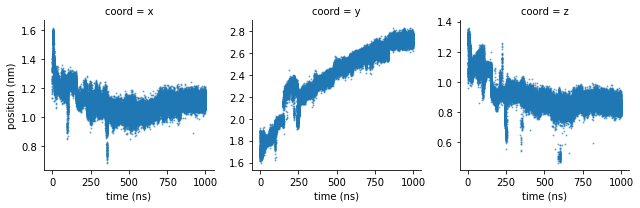

In [11]:
g = sns.FacetGrid(coor_melt.iloc[::100,:], col='coord', sharey=False)
g.map(plt.scatter, 't', 'value', alpha=0.5, s=1)
g.set_axis_labels('time (ns)', 'position (nm)')
plt.savefig('traj-4-xyz.png')

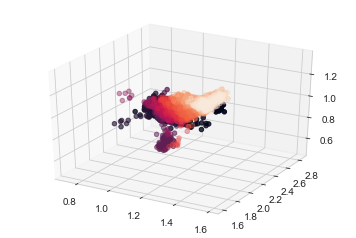

In [146]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1,projection='3d')
ax.scatter(xs=com[::1000,0], ys=com[::1000,1], zs=com[::1000,2], c=df['t'][::1000])



## Moving window MSM 

### Histogram window parameters

In [13]:
dt = traj.timestep/1000
xyz = com[:int(300/dt),:]
window = 10 # window size in ns
skip = 1 # skip in ns.  
nrows= int(window/dt)
nskip = int(skip/dt)
starts = np.arange(xyz.shape[0])[:-nrows:nskip]
print(len(starts))

291


### Histogram parameters

In [14]:
dr = 0.05 # histogram bin size in nm
xmin = -2
xmax = 2
r_tot = xmax-xmin
nbins = int(r_tot/dr)

In [68]:
!mkdir histogram_animation

mkdir: histogram_animation: File exists


In [69]:

t = df['t'].values
for i, start in enumerate(starts):
    print(i, end=', ')
    xyz_window = xyz[start:(start+nrows), 1]
#     print(xyz_window.shape)
    tica_obj = coor.tica(xyz_window, lag=int(0.1/dt), var_cutoff=0.9, kinetic_map=True)
    Y = tica_obj.get_output()[0]
    counts, bins = np.histogram(Y[:,0], bins=bins)
    F = -np.log(counts)
    F[np.isinf(F)]=0
    
    # Plot the y-axis trajectory
    fig, axes = plt.subplots(2,1)
    axes[0].scatter(t[::100], com[::100, 1], alpha=0.1)
    axes[0].scatter(t[start:(start+nrows):1], 
                    com[start:(start+nrows):1, 1], alpha=1)
    axes[0].set_ylabel('y-coordinate (nm)')
    axes[0].set_xlabel('time (ns)')
    
    # Plot the free energy vs 1st tica
    axes[1].plot(bins[:-1], F)
    axes[1].set_xlim(xmin, xmax)
    axes[1].set_ylim(-10, 0)
    axes[1].set_xlabel('tica-1-coordinate (nm)')
    axes[1].set_ylabel('Free energy (kT)')
    axes[1].set_title('{:4.2f}ns'.format(t[start]))
    plt.tight_layout()
    plt.savefig('histogram_animation/{:05d}.png'.format(i))
    plt.close(fig)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

In [70]:
!convert -loop 0 -delay 20 histogram_animation/*.png traj-4-free_energy.gif

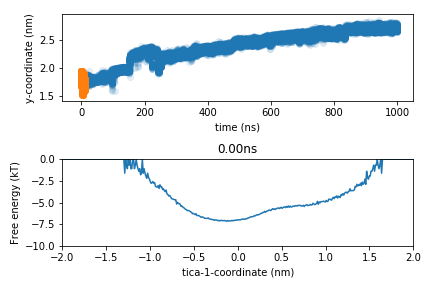

In [71]:
from IPython.display import Image
Image(filename='traj-4-free_energy.gif')

## Look at transition regions

### 1st Transition Region

In [15]:
start, stop = 148, 158
idx = (df['t']<stop) & (df['t'] > start)

xyz_window = df.loc[idx,'x':'z']
tica_obj = coor.tica(xyz_window, lag=int(0.1/dt), var_cutoff=0.9, kinetic_map=True)
Y = tica_obj.get_output()[0]



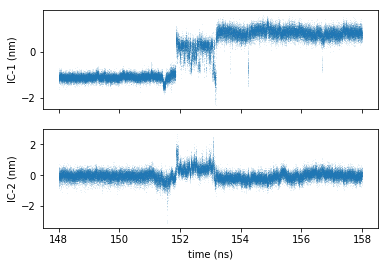

In [17]:
fig, axes = plt.subplots(Y.shape[1], sharex=True)
for i, ax in enumerate(axes):
    ax.scatter(df.loc[idx, 't'], Y[:,i], lw=0.05, alpha=0.1, marker='o', s=1)

    ax.set_ylabel('IC-{} (nm)'.format(i+1))
plt.xlabel('time (ns)')
plt.savefig('traj-4-tica-148.png')

### Second transition region

In [18]:
start, stop = 242, 252
idx = (df['t']<stop) & (df['t'] > start)

xyz_window = df.loc[idx,'x':'z']
tica_obj = coor.tica(xyz_window, lag=int(0.1/dt),dim=3, kinetic_map=True)
Y = tica_obj.get_output()[0]



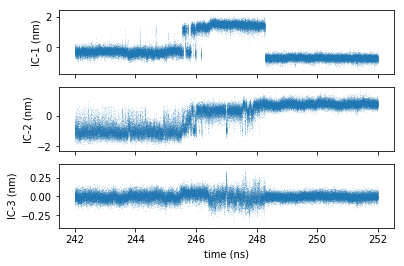

In [20]:
fig, axes = plt.subplots(Y.shape[1], sharex=True)
for i, ax in enumerate(axes):
    ax.scatter(df.loc[idx, 't'], Y[:,i], lw=0.05, alpha=0.1, marker='o', s=1)

    ax.set_ylabel('IC-{} (nm)'.format(i+1))
plt.xlabel('time (ns)')
plt.savefig('traj-4-tica-242.png')